In [1]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

from statsmodels.formula.api import ols

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adam, Adamax

from tensorflow.keras.layers import Dense, Concatenate, Activation
from tensorflow.keras.metrics import RootMeanSquaredError
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

In [2]:
#aa = "A01"
#aa = "A02"
aa = "A03"
#aa = "A04"
#aa = "A05"
#aa = "A06"
A0=pd.read_csv(aa+".csv",encoding="utf-8-sig")

In [3]:
A0["de_dt"] = pd.to_datetime(A0["de_dt"].astype(int).astype(str))
A0

,cust,pd_c,cop_c,de_dt,de_hr,buy_am,ma_fem_dv,ages,pd_nm,clac_hlv_nm,clac_mcls_nm
0,M396245045,PD1417,A03,2021-01-01,14,2990.0,여성,40대,샐러드류,채소,양채류
1,M396245045,PD1484,A03,2021-01-01,14,560.0,여성,40대,종량제봉투,청소/세탁/욕실용품,청소용품
2,M396245045,PD1417,A03,2021-01-01,14,4490.0,여성,40대,샐러드류,채소,양채류
3,M396245045,PD0727,A03,2021-01-01,14,15900.0,여성,40대,기타어류,수산물,어류
4,M396245045,PD1173,A03,2021-01-01,14,1000.0,여성,40대,생수,음료,생수
...,...,...,...,...,...,...,...,...,...,...,...
905703,M655525572,PD0324,A03,2021-12-31,23,7490.0,여성,40대,냉동디저트,냉동식품,냉동간편식
905704,M655525572,PD1161,A03,2021-12-31,23,1090.0,여성,40대,과일음료,음료,과채음료
905705,M655525572,PD1387,A03,2021-12-31,23,1690.0,여성,40대,두부류,채소,두부/콩나물류
905706,M655525572,PD1499,A03,2021-12-31,23,13280.0,여성,40대,국산돼지삼겹살,축산물,국산돼지고기


# 전처리

## 점수 base 생성

In [4]:
#raitings : 고객 별 상품 구매 횟수 count (대분류는 덤으로!)
A0_tmp = A0.value_counts(['cust','pd_c',"de_dt","clac_mcls_nm","clac_hlv_nm"]).reset_index().rename(columns={0:"buy_am"})
ratings=A0_tmp.groupby(['cust','pd_c',"clac_mcls_nm","clac_hlv_nm"],as_index=False).count()[['cust','pd_c',"clac_mcls_nm","clac_hlv_nm",'buy_am']]
ratings

,cust,pd_c,clac_mcls_nm,clac_hlv_nm,buy_am
0,M000225114,PD1152,가공유,유제품,1
1,M000225114,PD1156,우유,유제품,1
2,M000225114,PD1486,계란류,축산물,1
3,M000494848,PD0359,냉장음료,냉장식품,1
4,M000494848,PD1173,생수,음료,1
...,...,...,...,...,...
329811,M999962961,PD1543,미국산소고기,축산물,1
329812,M999962961,PD1546,수입돼지고기,축산물,1
329813,M999962961,PD1557,육가공품,축산물,3
329814,M999962961,PD1654,차류,커피/차,1


In [5]:
#고객 별 상품 대분류 별 구매 횟수
tmp = A0_tmp.groupby(['cust','clac_hlv_nm'],as_index=False).count()[['cust','clac_hlv_nm','buy_am']]
tmp

,cust,clac_hlv_nm,buy_am
0,M000225114,유제품,2
1,M000225114,축산물,1
2,M000494848,냉장식품,1
3,M000494848,음료,3
4,M000494848,조미료,1
...,...,...,...
98480,M999962961,채소,29
98481,M999962961,청소/세탁/욕실용품,2
98482,M999962961,축산물,16
98483,M999962961,커피/차,1


In [6]:
#고객 별 구매 횟수
tmp_ref = A0_tmp.groupby("cust",as_index=False).sum()[["cust","buy_am"]].rename(columns={"buy_am":"buy_sum"})
tmp_ref

,cust,buy_sum
0,M000225114,3
1,M000494848,8
2,M000504230,180
3,M000555652,2
4,M000705571,27
...,...,...
9415,M999180761,10
9416,M999238704,7
9417,M999441814,2
9418,M999770689,24


In [7]:
#참조1 : 고객 별 대분류 구매 비율 생성

ref1 = pd.merge(tmp,tmp_ref, how='left',on='cust')
ref1["buy_score_ref"] = ref1["buy_am"]/ref1["buy_sum"]
ref1 = ref1.drop(["buy_am","buy_sum"],axis=1)
ref1

,cust,clac_hlv_nm,buy_score_ref
0,M000225114,유제품,0.666667
1,M000225114,축산물,0.333333
2,M000494848,냉장식품,0.125000
3,M000494848,음료,0.375000
4,M000494848,조미료,0.125000
...,...,...,...
98480,M999962961,채소,0.195946
98481,M999962961,청소/세탁/욕실용품,0.013514
98482,M999962961,축산물,0.108108
98483,M999962961,커피/차,0.006757


In [8]:
#참조2 : 고객 별 상품 별 마지막 구매 날짜
score_update=A0_tmp.value_counts(['cust','pd_c','de_dt']).reset_index()[['cust','pd_c','de_dt']]
ref2 = score_update.groupby(["cust","pd_c"],as_index=False).max("de_dt").rename(columns={"de_dt":"last_dt"})
ref2

,cust,pd_c,last_dt
0,M000225114,PD1152,2021-03-09
1,M000225114,PD1156,2021-03-09
2,M000225114,PD1486,2021-03-09
3,M000494848,PD0359,2021-06-28
4,M000494848,PD1173,2021-06-28
...,...,...,...
329811,M999962961,PD1543,2021-12-17
329812,M999962961,PD1546,2021-08-07
329813,M999962961,PD1557,2021-10-13
329814,M999962961,PD1654,2021-02-26


In [9]:
#참조3 : 상품 별 고객 마다의 구매 간격들 평균 

tmp = A0_tmp.value_counts(['cust','pd_c','de_dt'])
date_file = tmp.reset_index()[['cust','pd_c','de_dt']]

qq = date_file.value_counts(["cust","pd_c"])[date_file.value_counts(["cust","pd_c"]) > 1].reset_index()[['cust','pd_c']]
qq

range_lst = []
for n in tqdm_notebook(range(len(qq))):
    i = qq.loc[n,"cust"]
    j = qq.loc[n,"pd_c"]
    tmp = date_file[(date_file["pd_c"] == j)&(date_file["cust"] == i)].sort_values("de_dt")
    for k in range(len(tmp)-1):
        range_lst.append({"pd_c":j,"range_mean":(tmp.iloc[k+1,2] - tmp.iloc[k,2]).days})
range_lst = pd.DataFrame(range_lst)

ref3 = range_lst.groupby("pd_c",as_index=False).mean("range_mean")[["pd_c","range_mean"]]

<ipython-input-9-5d7e158bef0e>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n in tqdm_notebook(range(len(qq))):


  0%|          | 0/130665 [00:00<?, ?it/s]

In [10]:
#합쳐주기!
ratings = pd.merge(ratings,ref1, how='left',on=['cust',"clac_hlv_nm"])
ratings = pd.merge(ratings,ref2, how='left',on=['cust',"pd_c"])
ratings = pd.merge(ratings,ref3, how='left',on='pd_c')
ratings = ratings.fillna(0)

ratings

,cust,pd_c,clac_mcls_nm,clac_hlv_nm,buy_am,buy_score_ref,last_dt,range_mean
0,M000225114,PD1152,가공유,유제품,1,0.666667,2021-03-09,38.179255
1,M000225114,PD1156,우유,유제품,1,0.666667,2021-03-09,26.975623
2,M000225114,PD1486,계란류,축산물,1,0.333333,2021-03-09,36.869342
3,M000494848,PD0359,냉장음료,냉장식품,1,0.125000,2021-06-28,36.138889
4,M000494848,PD1173,생수,음료,1,0.375000,2021-06-28,30.708948
...,...,...,...,...,...,...,...,...
329811,M999962961,PD1543,미국산소고기,축산물,1,0.108108,2021-12-17,53.222222
329812,M999962961,PD1546,수입돼지고기,축산물,1,0.108108,2021-08-07,52.670940
329813,M999962961,PD1557,육가공품,축산물,3,0.108108,2021-10-13,50.992857
329814,M999962961,PD1654,차류,커피/차,1,0.006757,2021-02-26,84.727273


## 점수체계

In [11]:
#구매 횟수 0~5점
ratings['buy_level']=np.where(ratings.buy_am>=24,5,
                       np.where(ratings.buy_am>=12,4,
                               np.where(ratings.buy_am>=6,3,
                                       np.where(ratings.buy_am>=4,2,
                                               np.where(ratings.buy_am>=3,1,0)))))

ratings['buy_level']=ratings['buy_level'].astype('float')

In [12]:
#대분류 0~5점

low_clac_lst = A0_tmp.value_counts(["cust","clac_hlv_nm"]).reset_index().rename(columns={0:"count"}).groupby("clac_hlv_nm",as_index=False).mean("count")[["clac_hlv_nm","count"]]

low_clac_lst["low_clac"] = np.where(low_clac_lst["count"] >= low_clac_lst["count"].quantile(q=15/21),5,
                       np.where(low_clac_lst["count"]>=low_clac_lst["count"].quantile(q=10/21),4,
                               np.where(low_clac_lst["count"]>=low_clac_lst["count"].quantile(q=6/21),3,
                                       np.where(low_clac_lst["count"]>=low_clac_lst["count"].quantile(q=3/21),2,
                                               np.where(low_clac_lst["count"]>=low_clac_lst["count"].quantile(q=1/21),1,0)))))


ratings = pd.merge(ratings, low_clac_lst.drop("count",axis=1), how='left',on = 'clac_hlv_nm')

In [13]:
#(구매 간격 / 평균 구매 간격)의 quantile 별 점수

##range_mean이 0인 애들의 대체값, 같은 대분류들 중 최대 구매간격
tmp_value = ratings[ratings["range_mean"] == 0].value_counts("clac_hlv_nm").reset_index().drop(0,axis=1)
tmp_m = []
for i in tqdm_notebook(tmp_value["clac_hlv_nm"]):
    tmp_m.append(ratings[(ratings["clac_hlv_nm"] == i) & (ratings["range_mean"] != 0)]["range_mean"].max())
tmp_value["tmp_m"] = tmp_m

ratings = pd.merge(ratings, tmp_value, how='left',on="clac_hlv_nm")
ratings.loc[ratings["range_mean"] != 0,"tmp_m"] = 0
ratings["tmp_m"] = ratings["tmp_m"].fillna(ratings["range_mean"].max())

today = pd.datetime(year = 2022, month = 1, day = 1)
ratings["range_result"] = (today - ratings["last_dt"]).dt.days / (ratings["range_mean"] + ratings["tmp_m"])


ratings["range_score"] = np.where(ratings["range_result"] >= ratings["range_result"].quantile(q=15/21),5,
                       np.where(ratings["range_result"]>=ratings["range_result"].quantile(q=10/21),4,
                               np.where(ratings["range_result"]>=ratings["range_result"].quantile(q=6/21),3,
                                       np.where(ratings["range_result"]>=ratings["range_result"].quantile(q=3/21),2,
                                               np.where(ratings["range_result"]>=ratings["range_result"].quantile(q=1/21),1,0)))))

<ipython-input-13-2b9e33574f74>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(tmp_value["clac_hlv_nm"]):


  0%|          | 0/33 [00:00<?, ?it/s]

<ipython-input-13-2b9e33574f74>:14: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  today = pd.datetime(year = 2022, month = 1, day = 1)


### 비율 확인

(array([254944.,      0.,  25466.,      0.,  23307.,      0.,  18578.,
             0.,   5803.,   1718.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

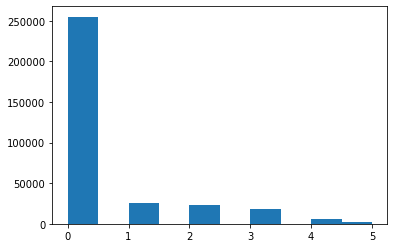

In [14]:
plt.hist(ratings["buy_level"], bins = np.arange(0,5.5,0.5))

(array([1.40000e+01, 0.00000e+00, 3.40000e+02, 0.00000e+00, 1.72000e+03,
        0.00000e+00, 2.23900e+03, 0.00000e+00, 4.48660e+04, 2.80637e+05]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

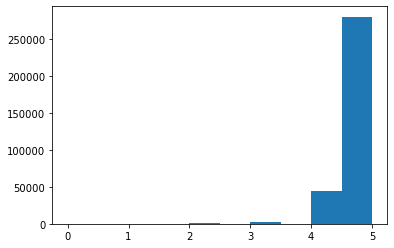

In [15]:
plt.hist(ratings["low_clac"], bins = np.arange(0,5.5,0.5))

(array([15704.,     0., 31411.,     0., 47117.,     0., 62820.,     0.,
        78530., 94234.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

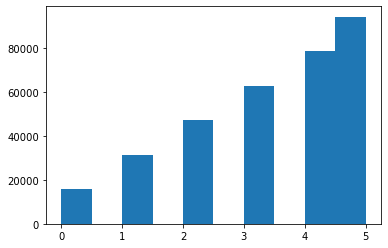

In [16]:
plt.hist(ratings["range_score"], bins = np.arange(0,5.5,0.5))

In [17]:
ratings["score"] = (ratings["buy_level"]*2 + ratings["low_clac"] + ratings["range_score"])/4

(array([3.10000e+01, 4.67000e+02, 1.23210e+04, 5.75960e+04, 1.20172e+05,
        9.95750e+04, 2.33330e+04, 1.25130e+04, 3.38000e+03, 4.28000e+02]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

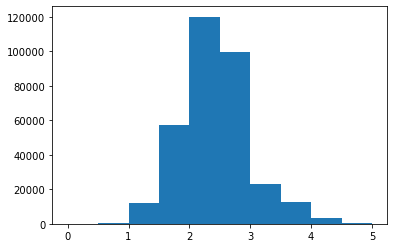

In [18]:
plt.hist(ratings["score"], bins = np.arange(0,5.5,0.5))

# 모델링

## LabelEncoding

In [19]:
le_c = LabelEncoder()
le_c = le_c.fit(ratings.cust)
ratings['cust']=le_c.transform(ratings.cust)
customer_info=pd.DataFrame(le_c.classes_, columns={'cust'})
customer_info['label']=range(0,len(ratings.cust.unique()))
customer_info.to_csv(aa+"_customer_info.csv",index=False)
customer_info

,cust,label
0,M000225114,0
1,M000494848,1
2,M000504230,2
3,M000555652,3
4,M000705571,4
...,...,...
9415,M999180761,9415
9416,M999238704,9416
9417,M999441814,9417
9418,M999770689,9418


In [20]:
le_p = LabelEncoder()
le_p = le_p.fit(ratings.pd_c)
ratings['pd_c']=le_p.transform(ratings.pd_c)
pd_info=pd.DataFrame(le_p.classes_, columns={'pd_c'})
pd_info['label']=range(0,len(ratings.pd_c.unique()))
pd_info.to_csv(aa+"_pd_info.csv",index=False)
pd_info

,pd_c,label
0,PD0010,0
1,PD0033,1
2,PD0035,2
3,PD0036,3
4,PD0038,4
...,...,...
837,PD1924,837
838,PD1925,838
839,PD1926,839
840,PD1928,840


In [21]:
# train test 분리
TRAIN_SIZE = 0.9
ratings = shuffle(ratings)
cutoff = int(TRAIN_SIZE * len(ratings))
ratings_train = ratings.iloc[:cutoff]
ratings_test = ratings.iloc[cutoff:]

In [22]:
users=A0.groupby(['cust','ages','ma_fem_dv'],as_index=False).count()
users=users[['cust','ages','ma_fem_dv']]
users['cust']=le_c.transform(users.cust)
users

,cust,ages,ma_fem_dv
0,0,40대,여성
1,1,30대,여성
2,2,30대,여성
3,3,50대,남성
4,4,40대,여성
...,...,...,...
9415,9415,30대,남성
9416,9416,30대,남성
9417,9417,50대,여성
9418,9418,30대,여성


In [23]:
ages=[]
for i in range(len(users)):
    users.ages[i]=users.ages[i][0:2]
users.ages=users.ages.astype('float')

<ipython-input-23-ab29fe5432dc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users.ages[i]=users.ages[i][0:2]


In [24]:
le_s = LabelEncoder()
le_s = le_s.fit(users.ma_fem_dv)
users['ma_fem_dv']=le_s.transform(users.ma_fem_dv)

customer_info['sex']=users['ma_fem_dv']
customer_info

,cust,label,sex
0,M000225114,0,1
1,M000494848,1,1
2,M000504230,2,1
3,M000555652,3,0
4,M000705571,4,1
...,...,...,...
9415,M999180761,9415,0
9416,M999238704,9416,0
9417,M999441814,9417,1
9418,M999770689,9418,1


In [25]:
users

,cust,ages,ma_fem_dv
0,0,40.0,1
1,1,30.0,1
2,2,30.0,1
3,3,50.0,0
4,4,40.0,1
...,...,...,...
9415,9415,30.0,0
9416,9416,30.0,0
9417,9417,50.0,1
9418,9418,30.0,1


In [26]:
L=len(customer_info)
train_asz = pd.merge(ratings_train, users, on='cust')[['ages','ma_fem_dv']]
test_asz = pd.merge(ratings_test, users, on='cust')[['ages','ma_fem_dv']]

## INPUT file (구매 경험이 없는 고객-상품 모음) 생성

In [27]:
ratings = pd.merge(ratings,users,how="left",on="cust")

#회귀분석을 이용한 score 관련 변수 확인하기
res = ols('score ~ ages+ma_fem_dv', data=ratings).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     23.63
Date:                Sun, 07 Aug 2022   Prob (F-statistic):           5.49e-11
Time:                        03:41:37   Log-Likelihood:            -2.7184e+05
No. Observations:              329816   AIC:                         5.437e+05
Df Residuals:                  329813   BIC:                         5.437e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2674      0.004    534.359      0.000       2.259       2.276
ages           0.0005   9.31e-05      5.766      0.000       0.000       0.001
ma_fem_dv     -0.0088      0.002     -3.936      0.000      -0.013      -0.004
==============================================================================
Omnibus:                    25616.389   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            40174.258
Skew:                           0.610   Prob(JB):                         0.00
Kurtosis:                       4.199   Cond. No.                         192.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
ratings.to_csv(aa+"_ratings.csv",index=False,encoding='utf-8-sig')
users.to_csv(aa+"_users.csv",index=False)

In [29]:
check = np.zeros(shape=(len(ratings["cust"].unique()), len(ratings["pd_c"].unique())), dtype=np.int8) - 999


for i in tqdm_notebook(range(len(ratings))):
    c_label = ratings.iloc[i,0]
    p_label = ratings.iloc[i,1]
    sco = ratings.iloc[i,-1]
    check[int(c_label)][int(p_label)] = sco
    
cust = np.where(check == -999)[0]
pd_c = np.where(check == -999)[1]
last = pd.DataFrame()
last["cust"] = cust
last["pd_c"] = pd_c
last = pd.merge(last,users,how="left",on="cust")
last.to_csv(aa+"_input.csv",index=False)

<ipython-input-29-ee852db894de>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(ratings))):


  0%|          | 0/329816 [00:00<?, ?it/s]

## Model Fitting

In [30]:
# Variable 초기화 
K = 200                             # Latent factor 수 
mu = ratings_train.score.mean()    # 전체 평균 
M = ratings.cust.max() + 1       
N = ratings.pd_c.max() + 1  

In [31]:
# Keras model
user = Input(shape=(1, ))
item = Input(shape=(1, ))
P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item)
user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user)
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item)

In [32]:
# Concatenate layers
P_embedding = Flatten()(P_embedding)
Q_embedding = Flatten()(Q_embedding)
user_bias = Flatten()(user_bias)
item_bias = Flatten()(item_bias)

In [33]:
age = Input(shape=(1, ))
age_embedding = Embedding(L, 3, embeddings_regularizer=l2())(age)
age_layer = Flatten()(age_embedding)

sex = Input(shape=(1, ))
sex_embedding = Embedding(L, 3, embeddings_regularizer=l2())(sex)
sex_layer = Flatten()(sex_embedding)

R = Concatenate()([P_embedding, Q_embedding, user_bias, item_bias, age_layer,sex_layer])

In [34]:
# Neural network
R = Dense(2048)(R)
R = Activation('relu')(R)
R = Dense(256)(R)
R = Activation('relu')(R)
R = Dense(1)(R)

In [35]:
model = Model(inputs=[user, item, age, sex], outputs=R)
model.compile(
  loss="mse",
  optimizer=SGD(),
  #optimizer=Adamax(),
  metrics=[RootMeanSquaredError()]
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                              

In [36]:
callbacks = [EarlyStopping(monitor='val_loss',
                                           patience=3),
             ModelCheckpoint(filepath=aa+'_best_model.h5',
                                             monitor='val_loss',
                                             save_best_only=True)]

In [37]:
# Model fitting
result = model.fit(
  x=[ratings_train.cust.values, ratings_train.pd_c.values, train_asz.ages, train_asz.ma_fem_dv],
  y=ratings_train.score.values - mu,
  epochs=1000,
  batch_size=512,
  validation_data=(
    [ratings_test.cust.values, ratings_test.pd_c.values, test_asz.ages, test_asz.ma_fem_dv],
    ratings_test.score.values - mu
  ), callbacks = callbacks
)

Epoch 1/1000
580/580 [==============================] - 16s 27ms/step - loss: 16.0699 - root_mean_squared_error: 0.5494 - val_loss: 14.3160 - val_root_mean_squared_error: 0.5567
Epoch 2/1000
580/580 [==============================] - 15s 27ms/step - loss: 12.8016 - root_mean_squared_error: 0.5464 - val_loss: 11.4120 - val_root_mean_squared_error: 0.5532
Epoch 3/1000
580/580 [==============================] - 16s 27ms/step - loss: 10.2082 - root_mean_squared_error: 0.5420 - val_loss: 9.1066 - val_root_mean_squared_error: 0.5475
Epoch 4/1000
580/580 [==============================] - 16s 28ms/step - loss: 8.1480 - root_mean_squared_error: 0.5345 - val_loss: 7.2736 - val_root_mean_squared_error: 0.5380
Epoch 5/1000
580/580 [==============================] - 16s 28ms/step - loss: 6.5092 - root_mean_squared_error: 0.5232 - val_loss: 5.8147 - val_root_mean_squared_error: 0.5245
Epoch 6/1000
580/580 [==============================] - 16s 28ms/step - loss: 5.2066 - root_mean_squared_error: 0.5

580/580 [==============================] - 16s 28ms/step - loss: 0.2018 - root_mean_squared_error: 0.4399 - val_loss: 0.2097 - val_root_mean_squared_error: 0.4488
Epoch 48/1000
580/580 [==============================] - 16s 28ms/step - loss: 0.2032 - root_mean_squared_error: 0.4417 - val_loss: 0.2089 - val_root_mean_squared_error: 0.4481
Epoch 49/1000
580/580 [==============================] - 16s 28ms/step - loss: 0.2013 - root_mean_squared_error: 0.4396 - val_loss: 0.2056 - val_root_mean_squared_error: 0.4446


## 결과 확인

In [38]:
keras_model_best = load_model(aa+'_best_model.h5')

<Figure size 576x576 with 0 Axes>

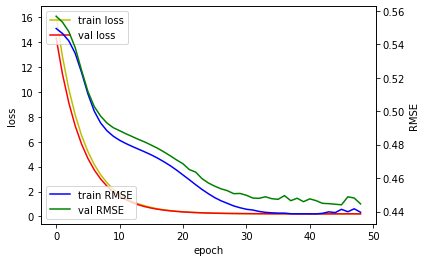

In [39]:
# Plot RMSE
plt.figure(figsize=(8,8))

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(result.history['loss'], 'y', label = 'train loss')
loss_ax.plot(result.history['val_loss'], 'r', label = 'val loss')

acc_ax.plot(result.history['root_mean_squared_error'], 'b', label = 'train RMSE')
acc_ax.plot(result.history['val_root_mean_squared_error'], 'g', label = 'val RMSE')


loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('RMSE')

loss_ax.legend(loc = 'upper left')
acc_ax.legend(loc = 'lower left')

plt.savefig(aa+'_model_loss.png')

In [40]:
# Prediction
user_ids = ratings_test.cust.values[100:110]
pd_ids = ratings_test.pd_c.values[100:110]
user_test = test_asz[100:110]
predictions = keras_model_best.predict([user_ids, pd_ids, user_test.ages, user_test.ma_fem_dv]) + mu
print("Actuals: \n", ratings_test[100:110]["score"])
print()
print("Predictions: \n", predictions)

Actuals: 
 324327    1.00
245781    2.50
121638    3.50
297742    2.25
290169    2.75
83043     2.75
305998    2.50
13608     2.50
134017    2.00
253659    2.00
Name: score, dtype: float64

Predictions: 
 [[1.146549 ]
 [2.067787 ]
 [2.8812997]
 [2.4423037]
 [2.3726919]
 [2.386781 ]
 [2.5625143]
 [2.32795  ]
 [2.2668386]
 [2.1871986]]


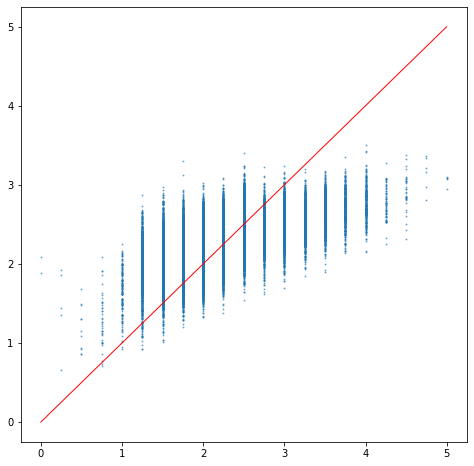

In [41]:
# Pred plot
user_ids = ratings_test.cust.values
pd_ids = ratings_test.pd_c.values
user_test = test_asz
predictions = keras_model_best.predict([user_ids, pd_ids, user_test.ages, user_test.ma_fem_dv]) + mu


plt.figure(figsize=(8,8))
plt.scatter(x = ratings_test.score, y = predictions, s=1, alpha = 0.5)
plt.plot([0, 5], [0, 5], color="red", lw=1, linestyle='solid')
plt.savefig(aa+'_test_predplot.png')

# OUTPUT file 생성

In [42]:
last["pred_score"] = keras_model_best.predict([last["cust"], last["pd_c"], last["ages"], last["ma_fem_dv"]]) + mu

In [43]:
last

,cust,pd_c,ages,ma_fem_dv,pred_score
0,0,0,40.0,1,1.937325
1,0,1,40.0,1,1.877761
2,0,2,40.0,1,1.971041
3,0,3,40.0,1,1.933221
4,0,4,40.0,1,2.003114
...,...,...,...,...,...
7601819,9419,837,50.0,1,1.728030
7601820,9419,838,50.0,1,1.902582
7601821,9419,839,50.0,1,1.683257
7601822,9419,840,50.0,1,1.617147


In [44]:
last.to_csv(aa+"_output.csv",index=False)